# CONAN in ~5 minutes

In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN3
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
CONAN3.__version__

'3.0.1'

 2 ways to use CONAN:
   - interactive setup in python environment
   - load setup from config file 

# Interactive 

The CONAN3 has 3 major classes that are used to store information about the input files and also perform computations.

They are:
- `load_lightcurves` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters. It contains methods to configure the LCs for fitting such as:

    - `lc_baseline`
    - `get_decorr`
    - `add_GP`
    - `setup_transit_rv`
    - `transit_depth_variation`
    - `setup_occulation`
    - `limb_darkening`
    - `contamination_factors`
    - `stellar_parameters`
    
    
- `load_rvs` : same as above but for rvs
- `mcmc_setup` : object to hold mcmc configuration

These objects are then given as input to the `fit_data` function to perform sampling. 

## WASP-52 example :

   - Transit Photometry: EULER CAM  and TESS
   - RV

## Setup light curve object

In [3]:
path = "data/"
lc_list  = ["lc6bjd.dat", "lc8det.dat"]

In [4]:
df = pd.read_fwf(path+lc_list[0], names=[f"cols{i}" for i in range(9)])
df.head(5)

,cols0,cols1,cols2,cols3,cols4,cols5,cols6,cols7,cols8
0,8209.555598,1.007264,0.000705,2.43,4.48,1.20,15.11,284.40,45.0
1,8209.556263,1.006767,0.000704,0.52,2.49,1.20,15.71,284.47,45.0
2,8209.556931,1.007128,0.000704,0.46,2.78,1.20,15.02,284.95,45.0
3,8209.557602,1.007728,0.000705,1.63,1.94,1.20,15.46,283.68,45.0
4,8209.558277,1.005616,0.000697,1.94,1.78,1.19,15.98,285.25,45.0


### load light curve into CONAN

In [5]:
lc_data = CONAN3.load_lightcurves(file_list     = lc_list, 
                                  data_filepath = path, 
                                  filters       = ["R","T"], 
                                  lamdas        = [600, 800])
lc_data

Filters: ['R', 'T']
Order of unique filters: ['R', 'T']


Object containing 2 lightcurves
Files:['lc6bjd.dat', 'lc8det.dat']
Filepath: data/

- The lc_data object holds information now about the light curves. The light curves can be plotted using the `plot` method of the object.

By default this plots column 0 (time) against column 1 (flux) with column 3(flux err) as uncertainties. 

- correlations between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 (roll angle) against column 1 (flux)

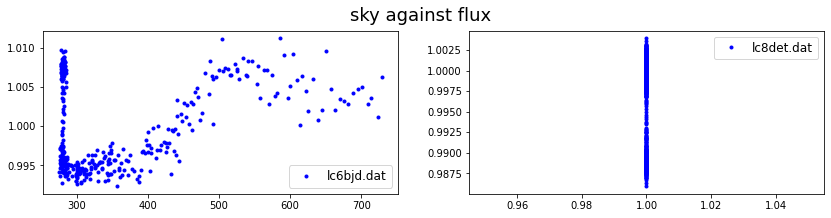

In [6]:
lc_data.plot(plot_cols=(7,1), col_labels=("sky","flux"))

### baseline and decorrelation parameters

- the baseline model for each lightcurve in the lc_data object can be defined using the `lc_baseline` method
- However the `get_decorr` method can be used to automatically determine the best decorrelation parameters to use. (Based on least-squares fit to the data and bayes factor comparison)


First, we would like take into account the transit when peforming the least-squares fit. so define the transit parameters to fit alongside

In [7]:
tra_occ_pars =dict(T_0  = (6776.624, 0.01),
                    P   = 4.178062,
                    dur = (0.15, 0.19, 0.22),
                    b   = (0, 0.35, 0.6),
                    rp  = (0.05, 0.108,0.15), 
                    q1  = (0.35, 0.4, 0.55), 
                    q2  = (0.20, 0.25, 0.35),
                    L   = 0 )


getting decorrelation parameters for lc: lc6bjd.dat (cheops=False)
BEST BIC:274.34, pars:['offset', 'A6', 'B7', 'A7']

getting decorrelation parameters for lc: lc8det.dat (cheops=False)
BEST BIC:-535.50, pars:['offset']


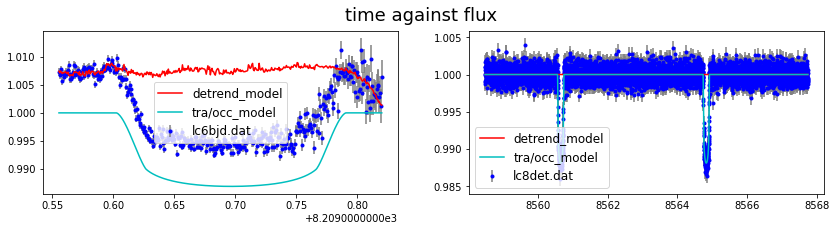

Setting-up baseline model from result
#--------------------------------------------- 
# Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
lc6bjd.dat     	R  	600.0	    0	   0	 0	 0	     1	   2	   0	     0	  1	 n 
lc8det.dat     	T  	800.0	    0	   0	 0	 0	     0	   0	   0	     0	  2	 n 
# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo

 Note: GP flag for each lc has been set to ['n', 'n']. Use `._useGPphot` method to modify this list with 'y' or 'n' for each loaded lc


Setting-up transit pars from input values
#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	y  	 0.10800	0.0010000	0.05	0.15	n	0.10800	0.0e+

In [18]:
lc_data.get_decorr( **tra_occ_pars, cheops=False)

In [8]:
# lc_data._useGPphot = ["y","n"]
# lc_data._gp_lcs = ["lc6bjd.dat"]

# lc_data.print("lc_baseline")

- manually define baseline for each lc

In [9]:
lc_data.lc_baseline(dconta = [2,0], 
                    dsky   = [2,0], 
                    gp     = ["y","n"])

#--------------------------------------------- 
# Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
lc6bjd.dat     	R  	600.0	    0	   0	 0	 0	     2	   2	   0	     0	  1	 y 
lc8det.dat     	T  	800.0	    0	   0	 0	 0	     0	   0	   0	     0	  2	 n 


### add GP

In [10]:
lc_data.add_GP(["lc6bjd.dat"],   pars = "time", 
                kernels = "mat32", WN = "y",
                log_scale  = [(-20, -16.5, -10)],
                log_metric = [(-12, -7.76, 0)]
                )

# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
lc6bjd.dat    time  mat32  y  6.8e-08 0.1000   0.0  0.00e+00 -10.0 -20.0 4.3e-04 0.1000  0.00  0.00e+00  0.0 -12.0


### Transit and RV parameters

In [11]:
lc_data.setup_transit_rv( RpRs      = (0, 0.105, 1),
                        Impact_para = (0.4, 0.1),
                        Duration    = (0.05, 0.18, 0.5),
                        T_0         = (6776.62, 0.001),
                        K           = (0, 20, 50),
                        Period      = 4.178062)

#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	y  	 0.10500	0.0100000	0.00	1.00	n	0.10500	0.0e+00	0.0e+00 
Impact_para 	y  	 0.40000	0.0010000	0.00	1.00	p	0.40000	1.0e-01	1.0e-01 
Duration    	y  	 0.18000	0.0045000	0.05	0.50	n	0.18000	0.0e+00	0.0e+00 
T_0         	y  	6776.62000	0.0000100	0.00	10000.00	p	6776.62000	1.0e-03	1.0e-03 
Period      	n  	 4.17806	0.0000000	0.00	10000.00	n	4.17806	0.0e+00	0.0e+00 
Eccentricity	n  	 0.00000	0.0000000	0.00	1.00	n	0.00000	0.0e+00	0.0e+00 
omega       	n  	90.00000	0.0000000	0.00	360.00	n	90.00000	0.0e+00	0.0e+00 
K           	y  	20.00000	0.5000000	0.00	50.00	n	20.00000	0.0e+00	0.0e+00 


### limb darkening

In [12]:
lc_data.limb_darkening(c1 = 0.421, #(0.01,0.421,0.01),
                       c2 = 0.213)#(0.01,0.213,0.01),)

#=========== Limb darkending setup ===================================================================
filters priors	c_1  step1  low_lim1  up_lim1	c_2  step2 low_lim2 up_lim2
R       n     	0.421 0.000  0.0000  0.0000	0.213 0.000  0.0000  0.0000
T       n     	0.421 0.000  0.0000  0.0000	0.213 0.000  0.0000  0.0000


### optional setups

In [13]:
lc_data.stellar_parameters(R_st = (1.333, 0.027),
                           M_st = (0.950, 0.02))

#=========== Stellar input properties ================================================================
# parameter    value  sig_lo  sig_hi 
Radius_[Rsun]  1.333  0.027  0.027 
Mass_[Msun]    0.950  0.020  0.020
Stellar_para_input_method:_R+rho_(Rrho),_M+rho_(Mrho),_M+R_(MR): MR


- filter dependent 

In [14]:
lc_data.transit_depth_variation()
lc_data.setup_occultation()
lc_data.contamination_factors()


#=========== ddF setup ============================================================================== 
Fit_ddFs  step	 low_lim   up_lim   prior   sig_lo   sig_hi   div_white
n         0.001	 -1.0000   1.0000   n       0.00000   0.00000   n  
group_ID   RpRs_0   err		dwfile
     1	   0.1000   1.00e-04   dw_001.dat
     2	   0.1000   1.00e-04   dw_002.dat
Not fitting occultation

#=========== occultation setup ============================================================================= 
filters	fit start_val	stepsize  low_lim   up_lim    prior  value     sig_lo  	sig_hi  
R      	n   0.000e+00	0.00e+00  0.00e+00  0.00e+00  n      0.00e+00  0.00e+00	0.00e+00 
T      	n   0.000e+00	0.00e+00  0.00e+00  0.00e+00  n      0.00e+00  0.00e+00	0.00e+00 
#=========== contamination setup === give contamination as flux ratio ================================
filters	contam	err
R      	0.0000	0.0000
T      	0.0000	0.0000


### visualize all light curve setup or different sections

In [15]:
lc_data.print("gp")    #no argument prints all setup

# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
lc6bjd.dat    time  mat32  y  6.8e-08 0.1000   0.0  0.00e+00 -10.0 -20.0 4.3e-04 0.1000  0.00  0.00e+00  0.0 -12.0


## Setup RV

In [16]:
rv_list = ["rv1.dat","rv2.dat"]

In [17]:
rv_data = CONAN3.load_rvs(file_list = rv_list, data_filepath=path)
rv_data

Next: use method `rv_baseline` to define baseline model for for the each rv


Object containing 2 rvs
Files:['rv1.dat', 'rv2.dat']
Filepath: data/

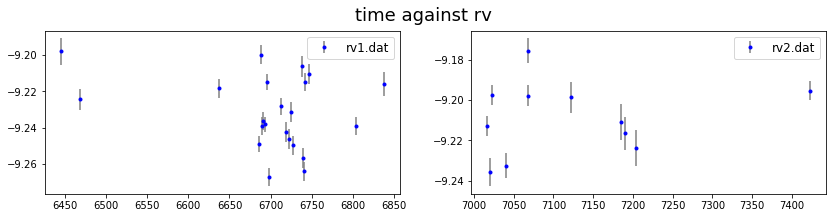

In [18]:
rv_data.plot()

In [19]:
rv_data.rv_baseline(gammas_kms = [(-9.235,0.01),(-9.205,0.01)])

# ------------------------------------------------------------
# Input RV curves, baseline function, gamma  
name            time  bis  fwhm  contrast  sinPs  gamma_kms  stepsize  prior  value  sig_lo  sig_hi
rv1.dat            0    0     0         0      0    -9.2350    0.0100  y      -9.2350  0.0100  0.0100
rv2.dat            0    0     0         0      0    -9.2050    0.0100  y      -9.2050  0.0100  0.0100


- turn off RV fit 

In [20]:
# rv_data = CONAN3.load_rvs()

# lc_data._config_par["K"].to_fit = "n"
# lc_data._config_par["K"].step_size = 0

## Setup MCMC

In [21]:
mcmc = CONAN3.mcmc_setup(n_chains = 64, n_burn   = 1000,
                         n_cpus   = 6, n_steps  = 1000, 
                         leastsq_for_basepar="y", apply_jitter="y")

#=========== MCMC setup ==============================================================================
Total_no_steps           64000 
Number_chains            64 
Number_of_processes      6 
Burnin_length            1000 
Walk_(snooker/demc/mrw)  None 
GR_test_(y/n)            y 
Make_plots_(y/n)         n 
leastsq_(y/n)            y 
Savefile                 output_ex1.npy 
Savemodel                n 
Adapt_base_stepsize      y 
Remove_param_for_CNM     n 
leastsq_for_basepar      y 
lssq_use_Lev-Marq        n 
apply_CFs                y 
apply_jitter             y


## Export configuration

In [27]:
CONAN3.create_configfile(lc_data, rv_data, mcmc,
                         filename='my_input_config.dat')

In [29]:
fg = ["y","n","y", "y"]
np.array(fg) != "n" 

array([ True, False,  True,  True])

## Performing the fit

finally perform the fitting which is saved to a `results` object that holds the chains of the mcmc and allows subsequent plotting

In [22]:
result = CONAN3.fit_data(lc_data,rv_data, mcmc);

CONAN3 launched!!!

Setting up photometry arrays ...
does jitter work?
does jitter work?
Setting up photometry GPs ...
Setting up RV arrays ...

Plotting initial guess

Lightcurve number: 0
GP values used: [-19.80697511 -16.5         -7.76      ]
writing init with gp to file
Running LSQ on baseline model

Running MCMC
No of dimensions:  12
No of chains:  64
fitting parameters:  ['T_0' 'RpRs' 'b' 'dur_[d]' 'K' 'rv1.dat_gamma' 'rv1.dat_jitter'
 'rv2.dat_gamma' 'rv2.dat_jitter' 'GPphotWN_lc1' 'GPphotscale_lc1dim0'
 'GPphotmetric_lc1dim0']

Running first burn-in...


100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Running second burn-in...


  4%|██▌                                                                   | 37/1000 [00:14<06:17,  2.55it/s]Process ForkPoolWorker-6:


emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-4:



emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:


emcee: Exception while calling your likelihood function:  params:

Traceback (most recent call last):
Traceback (most recent call last):


  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  params:

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()



  params:

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


[ 6.77662000e+03  1.00080156e-01  4.00292847e-01  1.84909503e-01
  1.99337178e-02 -9.22926775e+00  1.40932473e-03 -9.21071769e+00
  7.52175270e-04 -1.97557391e+01 -1.64675760e+01 -7.80684295e+00] 

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  params: 

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()


  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()


 [ 6.77662001e+03  1.01153992e-01  4.00533001e-01  1.80747964e-01
  1.98597603e-02 -9.22176495e+00  1.49789424e-03 -9.20657299e+00
 -9.28483135e-04 -1.97990726e+01 -1.65223315e+01 -7.80922561e+00]

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:


[ 6.77662000e+03  8.05733257e-02  3.99563598e-01  1.84296289e-01
  2.02242103e-02 -9.23587800e+00 -1.31810260e-03 -9.21046198e+00
  1.27908459e-03 -1.95565176e+01 -1.66326897e+01 -7.74420406e+00]  args:

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/queues.py", line 366, in get
    res = self._reader.recv_bytes()


  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


[ 6.77661999e+03  1.17900165e-01  3.98871212e-01  1.89159272e-01
  1.96030485e-02 -9.21319866e+00 -8.11780006e-04 -9.20157242e+00
  8.15764338e-05 -1.97249475e+01 -1.65694754e+01 -7.61420197e+00]
 

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)


  args:

KeyboardInterrupt: 

KeyboardInterrupt


  args:

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)


   args:[array([8209.555598 , 8209.556263 , 8209.556931 , ..., 7190.482339 ,
       7204.4773752, 7422.6878084]), array([ 1.007264,  1.006767,  1.007128, ..., -9.216467, -9.223938,
       -9.195379]), array([2.43, 0.52, 0.46, ..., 0.  , 0.  , 0.  ]), array([4.48, 2.49, 2.78, ..., 0.  , 0.  , 0.  ]), array([15.11    , 15.71    , 15.02    , ...,  8.113918,  8.125063,
        8.138234]), array([1.2, 1.2, 1.2, ..., 0. , 0. , 0. ]), array([-72.42372449, -72.35372449, -71.87372449, ...,   0.        ,
         0.        ,   0.        ]), array([ 0.      ,  0.      ,  0.      , ..., -0.007642,  0.00538 ,
       -0.013134]), array([ 0.      ,  0.      ,  0.      , ..., 35.965598, 35.399048,
       35.505446]), 2, 2, [(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50

  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt


  kwargs:[array([8209.555598 , 8209.556263 , 8209.556931 , ..., 7190.482339 ,
       7204.4773752, 7422.6878084]), array([ 1.007264,  1.006767,  1.007128, ..., -9.216467, -9.223938,
       -9.195379]), array([2.43, 0.52, 0.46, ..., 0.  , 0.  , 0.  ]), array([4.48, 2.49, 2.78, ..., 0.  , 0.  , 0.  ]), array([15.11    , 15.71    , 15.02    , ...,  8.113918,  8.125063,
        8.138234]), array([1.2, 1.2, 1.2, ..., 0. , 0. , 0. ]), array([-72.42372449, -72.35372449, -71.87372449, ...,   0.        ,
         0.        ,   0.        ]), array([ 0.      ,  0.      ,  0.      , ..., -0.007642,  0.00538 ,
       -0.013134]), array([ 0.      ,  0.      ,  0.      , ..., 35.965598, 35.399048,
       35.505446]), 2, 2, [(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  5

       [0]], dtype=object), 'y', (array([0, 1, 2]),), array([0.1, 0.1, 0.1]), array([0., 0., 0.])]
[array([8209.555598 , 8209.556263 , 8209.556931 , ..., 7190.482339 ,
       7204.4773752, 7422.6878084]), array([ 1.007264,  1.006767,  1.007128, ..., -9.216467, -9.223938,
       -9.195379]), array([2.43, 0.52, 0.46, ..., 0.  , 0.  , 0.  ]), array([4.48, 2.49, 2.78, ..., 0.  , 0.  , 0.  ]), array([15.11    , 15.71    , 15.02    , ...,  8.113918,  8.125063,
        8.138234]), array([1.2, 1.2, 1.2, ..., 0. , 0. , 0. ]), array([-72.42372449, -72.35372449, -71.87372449, ...,   0.        ,
         0.        ,   0.        ]), array([ 0.      ,  0.      ,  0.      , ..., -0.007642,  0.00538 ,
       -0.013134]), array([ 0.      ,  0.      ,  0.      , ..., 35.965598, 35.399048,
       35.505446]), 2, 2, [(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,

       [0]], dtype=object), 'y', (array([0, 1, 2]),), array([0.1, 0.1, 0.1]), array([0., 0., 0.])] [array([8209.555598 , 8209.556263 , 8209.556931 , ..., 7190.482339 ,
       7204.4773752, 7422.6878084]), array([ 1.007264,  1.006767,  1.007128, ..., -9.216467, -9.223938,
       -9.195379]), array([2.43, 0.52, 0.46, ..., 0.  , 0.  , 0.  ]), array([4.48, 2.49, 2.78, ..., 0.  , 0.  , 0.  ]), array([15.11    , 15.71    , 15.02    , ...,  8.113918,  8.125063,
        8.138234]), array([1.2, 1.2, 1.2, ..., 0. , 0. , 0. ]), array([-72.42372449, -72.35372449, -71.87372449, ...,   0.        ,
         0.        ,   0.        ]), array([ 0.      ,  0.      ,  0.      , ..., -0.007642,  0.00538 ,
       -0.013134]), array([ 0.      ,  0.      ,  0.      , ..., 35.965598, 35.399048,
       35.505446]), 2, 2, [(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,

       [0]], dtype=object), 'y', (array([0, 1, 2]),), array([0.1, 0.1, 0.1]), array([0., 0., 0.])]
  kwargs:{}
  kwargs: 
  kwargs: {}  exception: {}

{}
  exception:
  exception:

  exception:

Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tunde/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/Users/tunde/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/tunde/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/logprob_multi_sin_v4.py", line 332, in logprob_multi
    lnprob_thislc = gp.log_likelihood(ft, argu, quiet=True)
  File "/Users/tunde/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/logprob_multi_sin_v4.p

  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/gpnew.py", line 364, in log_likelihood
    mu = self._call_mean(self._x, args)
  File "/Users/tunde/miniconda3/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/gpnew.py", line 139, in _call_mean
    mu = self.mean.get_value(x, args).flatten()
  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/logprob_multi_sin_v4.py", line 332, in logprob_multi
    lnprob_thislc = gp.log_likelihood(ft, argu, quiet=True)
  File "/Users/tunde/Library/CloudStorage/OneDrive-unige.ch/mygit/CONAN3/CONAN3/gpnew.py", line 139, in _call_mean
    mu = self.mean.get_value(x, args).flatten()
  File "/Users/tunde/miniconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/tunde/Library/CloudStorage/OneDrive-u

In [32]:
result =CONAN3.load_chains()

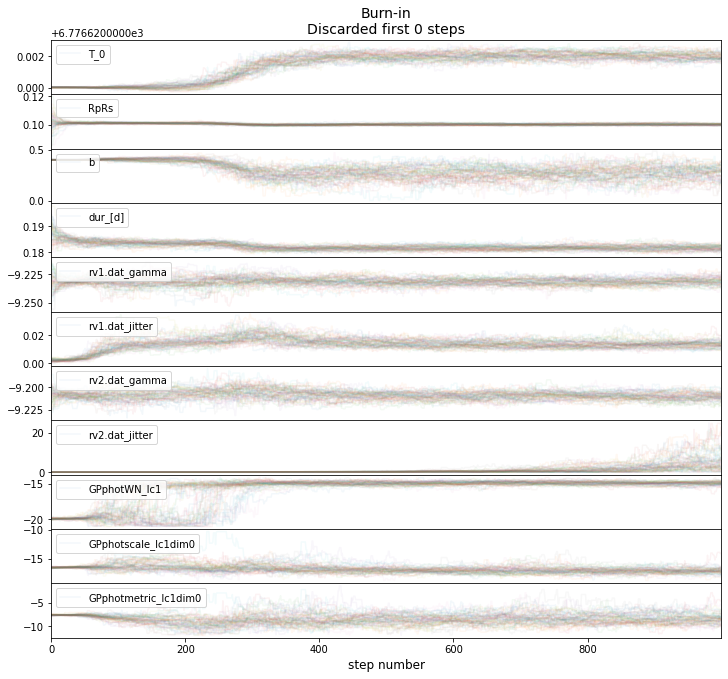

In [33]:
result.plot_burnin_chains();

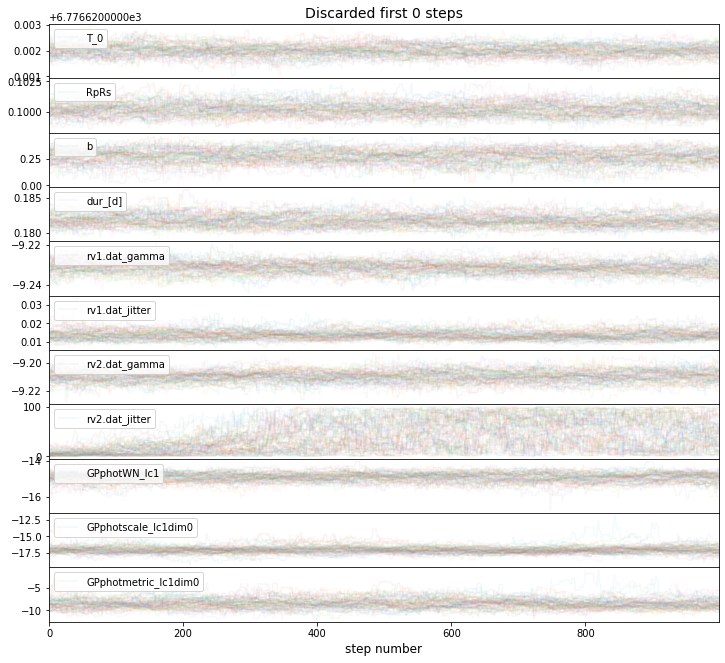

In [34]:
result.plot_chains();

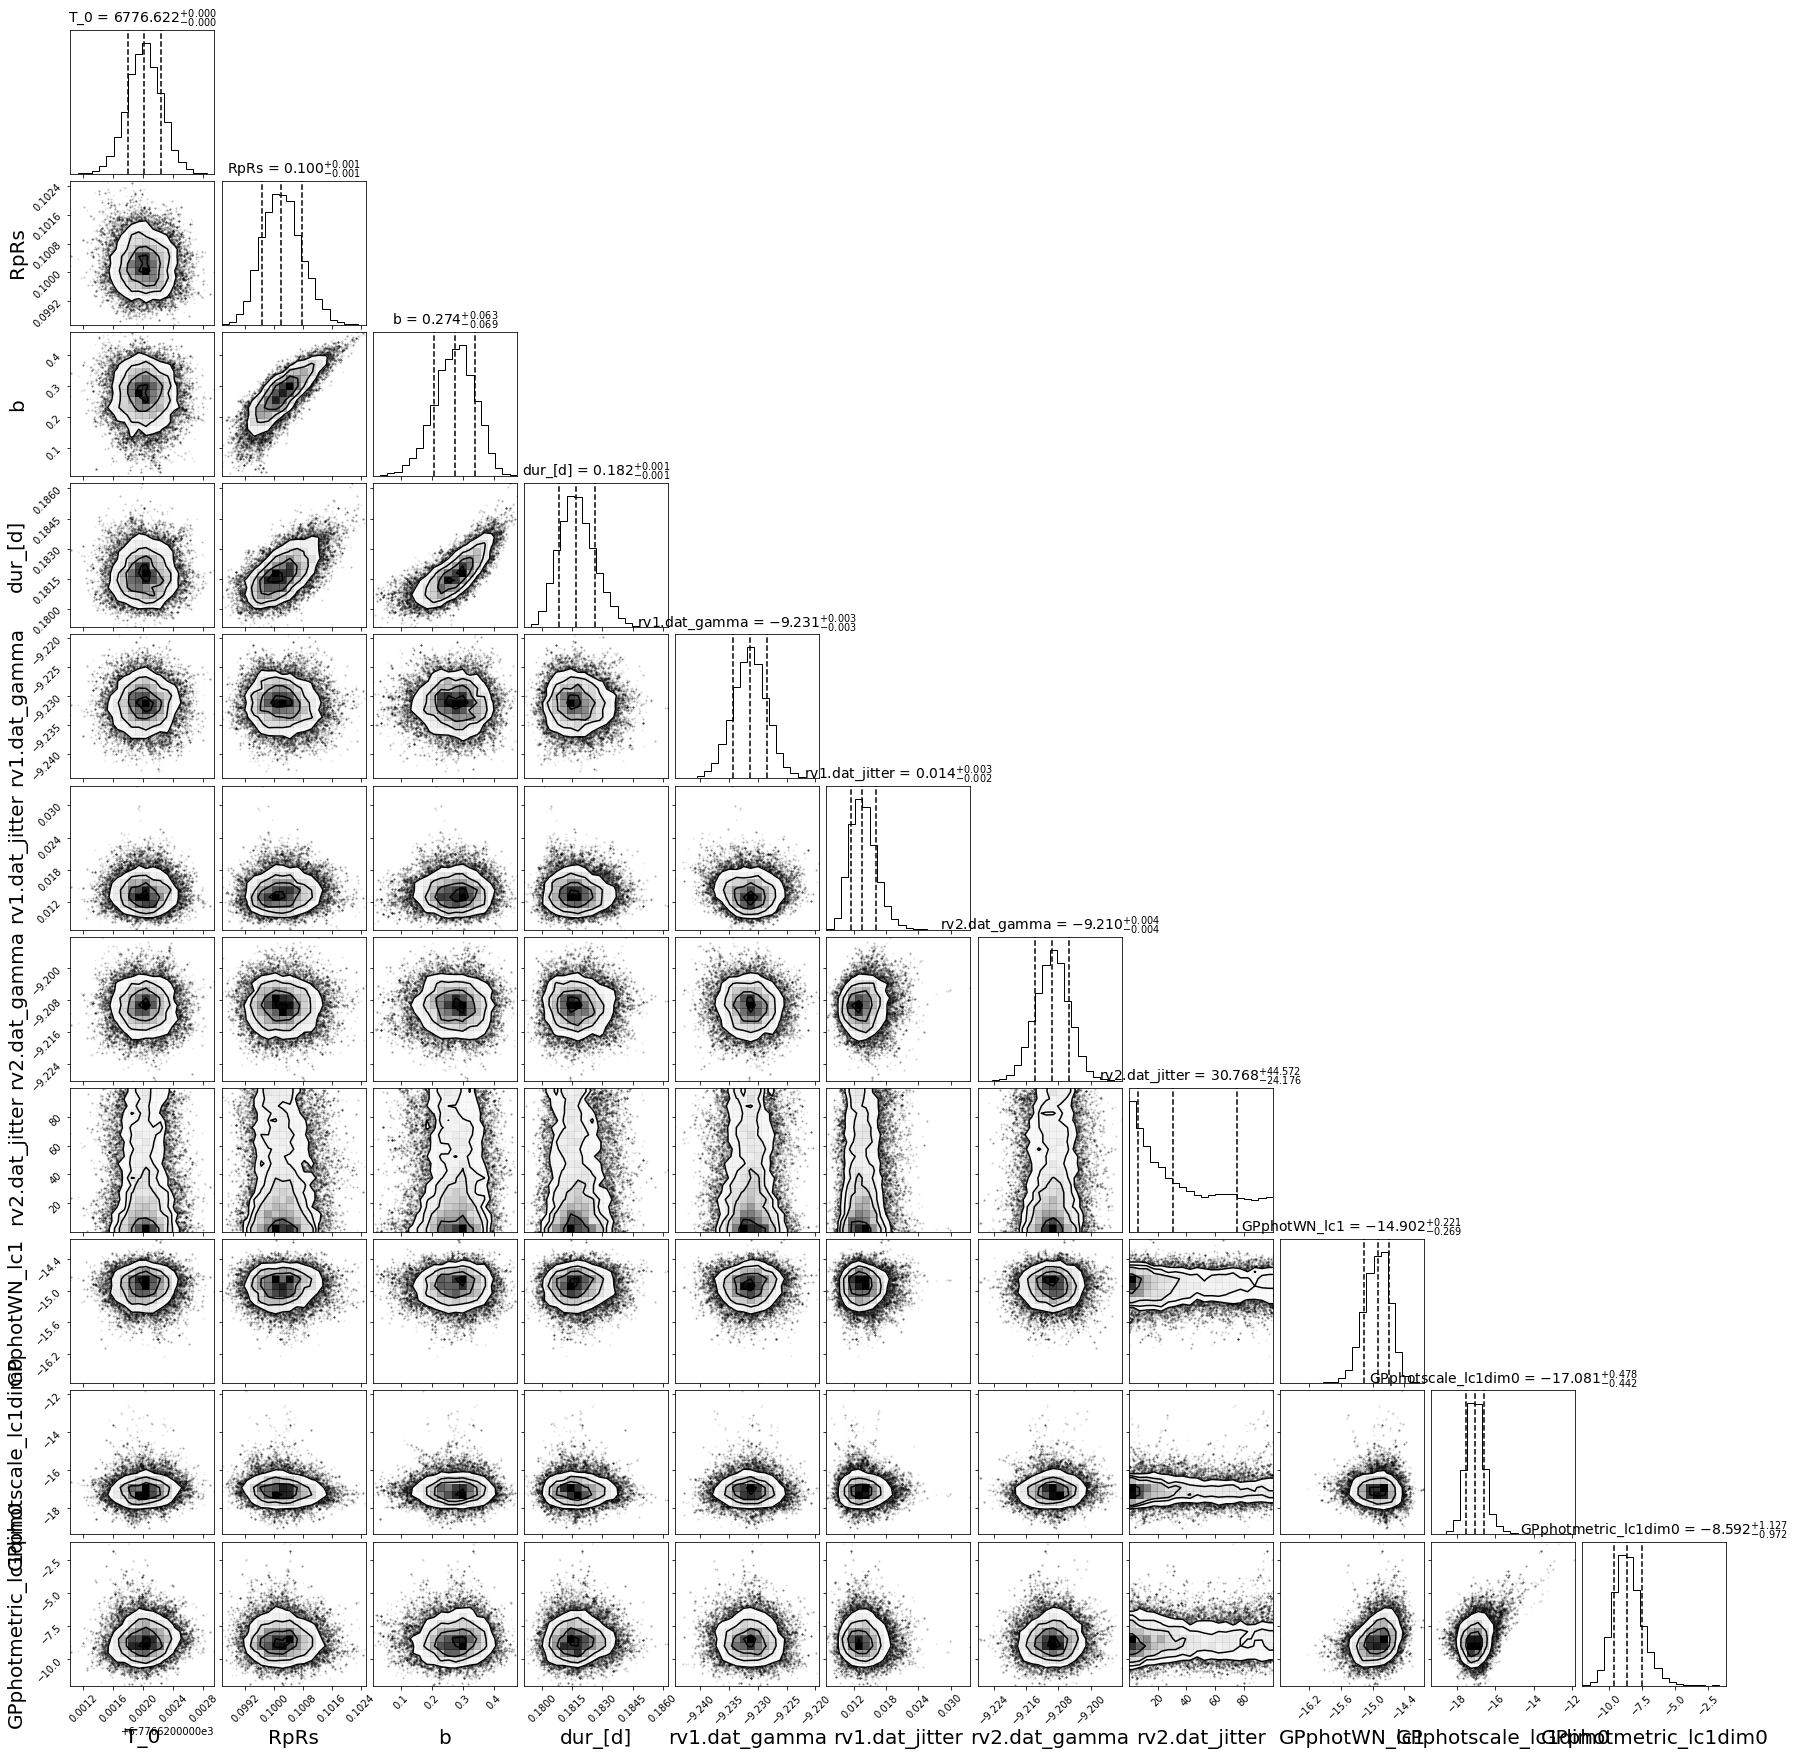

In [35]:
result.plot_corner(force_plot=True);

## load config file

- backwards compatible

In [ ]:
lc_data,rv_data,mcmc= CONAN3.load_configfile("my_input_config.dat",verbose=False)
lc_data

- perform fit as before

In [ ]:
result = CONAN3.fit_data(lc_data, rv_data, mcmc);